In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk

from scipy.stats import zscore
from scipy.sparse import hstack, save_npz
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/nixwill/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nixwill/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv(
    '../data/raw/winemag-data-130k-v2.csv',
    usecols=(
        'points',
        'price',
        'country',
        # 'province',
        # 'variety',
        'taster_name',
        'description',
    ),
)
df

,country,description,points,price,taster_name
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Kerin O’Keefe
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Roger Voss
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Paul Gregutt
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Alexander Peartree
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Paul Gregutt
...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,90,28.0,Anna Lee C. Iijima
129967,US,Citation is given as much as a decade of bottl...,90,75.0,Paul Gregutt
129968,France,Well-drained gravel soil gives this wine its c...,90,30.0,Roger Voss
129969,France,"A dry style of Pinot Gris, this is crisp with ...",90,32.0,Roger Voss


In [3]:
df = df.dropna()
df.shape

(96420, 5)

In [4]:
df = df.drop_duplicates()
df.shape

(88261, 5)

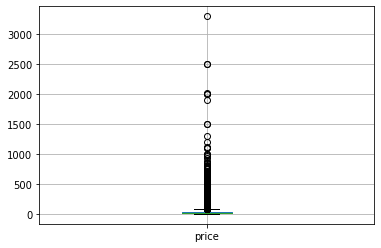

In [5]:
df.boxplot(column='price')
plt.show()

In [6]:
df = df[np.abs(zscore(df['price'])) < 3]
df.shape

(87416, 5)

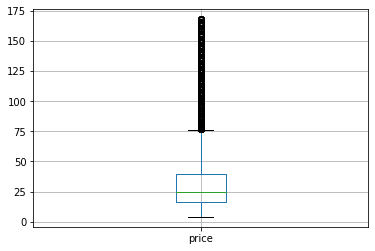

In [7]:
df.boxplot(column='price')
plt.show()

In [8]:
def points2group(row):
    """
    Convert points to it's group according to WineMag
    """
    if 80 <= row['points'] <= 82:
        return '80-82'
    if 83 <= row['points'] <= 86:
        return '83-86'
    if 87 <= row['points'] <= 89:
        return '87-89'
    if 90 <= row['points'] <= 93:
        return '90-93'
    if 94 <= row['points'] <= 97:
        return '94-97'
    if 98 <= row['points'] <= 100:
        return '98-100'
    return 'UNKNOWN'

df['points_group'] = df.apply(points2group, axis=1)

In [9]:
train_df, test_df = train_test_split(df, random_state=42, test_size=0.2)
print('Train size:', train_df.shape)
print('Test size:', test_df.shape)

Train size: (69932, 6)
Test size: (17484, 6)


In [10]:
# vector [ points, price, points^2, price^2, points * price ]
poly = PolynomialFeatures(2, include_bias=False)
poly_train = poly.fit_transform(train_df[['points', 'price']])
poly_test = poly.transform(test_df[['points', 'price']])

print('Before:')
print(train_df[['points', 'price']])
print('\nAfter:')
print(poly_train)

Before:
        points  price
66990       85   10.0
116827      94   38.0
15192       95   82.0
75988       89   18.0
65534       84   15.0
...        ...    ...
8585        89   30.0
79294       88   23.0
113114      88   50.0
1140        84   25.0
21840       80   18.0

[69932 rows x 2 columns]

After:
[[  85.   10. 7225.  850.  100.]
 [  94.   38. 8836. 3572. 1444.]
 [  95.   82. 9025. 7790. 6724.]
 ...
 [  88.   50. 7744. 4400. 2500.]
 [  84.   25. 7056. 2100.  625.]
 [  80.   18. 6400. 1440.  324.]]


In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(poly_train)
scaled_test = scaler.transform(poly_test)

print('Before:')
print(poly_train)
print('\nAfter:')
print(scaled_train)

Before:
[[  85.   10. 7225.  850.  100.]
 [  94.   38. 8836. 3572. 1444.]
 [  95.   82. 9025. 7790. 6724.]
 ...
 [  88.   50. 7744. 4400. 2500.]
 [  84.   25. 7056. 2100.  625.]
 [  80.   18. 6400. 1440.  324.]]

After:
[[0.25       0.03658537 0.22916667 0.03339304 0.00297788]
 [0.7        0.20731707 0.67666667 0.20752303 0.05062394]
 [0.75       0.47560976 0.72916667 0.47735415 0.23780488]
 ...
 [0.4        0.2804878  0.37333333 0.2604913  0.08806012]
 [0.2        0.12804878 0.18222222 0.11335722 0.02158962]
 [0.         0.08536585 0.         0.07113613 0.01091889]]


In [12]:
enc = OneHotEncoder(handle_unknown='ignore')
enc_train = enc.fit_transform(train_df[['country', 'taster_name']])
enc_test = enc.transform(test_df[['country', 'taster_name']])

print('Before:')
print(train_df[['country', 'taster_name']])
print('\nAfter:')
print(enc_train.toarray())
print(enc_train.shape)

Before:
          country         taster_name
66990   Argentina   Michael Schachner
116827      Italy       Kerin O’Keefe
15192          US       Matt Kettmann
75988     Germany  Anna Lee C. Iijima
65534          US  Anna Lee C. Iijima
...           ...                 ...
8585    Australia      Joe Czerwinski
79294      France          Roger Voss
113114    Germany      Joe Czerwinski
1140           US  Anna Lee C. Iijima
21840       Chile   Michael Schachner

[69932 rows x 2 columns]

After:
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(69932, 60)


In [13]:
ord_enc = OrdinalEncoder()
points_group_train = ord_enc.fit_transform(train_df[['points_group']])
points_group_test = ord_enc.transform(test_df[['points_group']])

print('Before:')
print(train_df[['points_group']])
print('\nAfter:')
print(points_group_train)

Before:
       points_group
66990         83-86
116827        94-97
15192         94-97
75988         87-89
65534         83-86
...             ...
8585          87-89
79294         87-89
113114        87-89
1140          83-86
21840         80-82

[69932 rows x 1 columns]

After:
[[1.]
 [4.]
 [4.]
 ...
 [2.]
 [1.]
 [0.]]


In [14]:
class PorterTokenizer:

    def __init__(self):
        self.stemmer = PorterStemmer()
        self.stopwords = set(stopwords.words('english'))
        self.stopwords.add("'")

    def __call__(self, doc):
        return [self.stemmer.stem(token) for token in wordpunct_tokenize(doc) if token not in self.stopwords]

In [15]:
vectorizer_1g = TfidfVectorizer(
    tokenizer=PorterTokenizer(),
    ngram_range=(1, 1),
    max_df=0.7,
    min_df=7,
)

tf_idf_1g_train = vectorizer_1g.fit_transform(train_df['description'])
tf_idf_1g_test = vectorizer_1g.transform(test_df['description'])

tf_idf_1g_train.shape

(69932, 5797)

In [16]:
vectorizer_2g = TfidfVectorizer(
    tokenizer=PorterTokenizer(),
    ngram_range=(1, 2),
    max_df=0.7,
    min_df=7,
)

tf_idf_2g_train = vectorizer_2g.fit_transform(train_df['description'])
tf_idf_2g_test = vectorizer_2g.transform(test_df['description'])

tf_idf_2g_train.shape

(69932, 42494)

In [17]:
csr_train_1g = hstack(
    (
        points_group_train,
        scaled_train,
        enc_train,
        tf_idf_1g_train,
    ),
    format='csr',
)
save_npz('../data/preprocessed/1-gram/train.npz', csr_train_1g)
csr_train_1g.shape

(69932, 5863)

In [18]:
csr_test_1g = hstack(
    (
        points_group_test,
        scaled_test,
        enc_test,
        tf_idf_1g_test,
    ),
    format='csr',
)
save_npz('../data/preprocessed/1-gram/test.npz', csr_test_1g)
csr_test_1g.shape

(17484, 5863)

In [19]:
csr_train_2g = hstack(
    (
        points_group_train,
        scaled_train,
        enc_train,
        tf_idf_2g_train,
    ),
    format='csr',
)
save_npz('../data/preprocessed/2-gram/train.npz', csr_train_2g)
csr_train_2g.shape

(69932, 42560)

In [20]:
csr_test_2g = hstack(
    (
        points_group_test,
        scaled_test,
        enc_test,
        tf_idf_2g_test,
    ),
    format='csr',
)
save_npz('../data/preprocessed/2-gram/test.npz', csr_test_2g)
csr_test_2g.shape


(17484, 42560)